# Landmark detection and cropping

As discussed in the face detection tutorial, there is a lot of preprocessing needed before we can feed images to the reconstruction models. One important step is *cropping*, which crops out the detected face(s) from the image standarizes the output into a new image with prespecified dimensions. Some models crop the image by specifying a bounding box, which is often constructed by creating a rectangular box around a set of estimated facial features (also called face *landmarks*).

Other models (like MICA, or any model based on Arcface for that matter) expect images not only to be cropped, but also *aligned*. Here, alignment means that certain key  facial landmarks of a cropped face are as close as possible relative to a template set of landmarks.

Medusa includes implementation of both bounding-box based as well as alignment-based "crop models", `BboxCropModel` (used for DECA-based reconstruction models) and `AlignCropModel` (used for MICA). Note that the `Mediapipe` reconstruction model does not need cropping (which is performed by the `Mediapipe` model itself).

But before we discuss cropping, let's discuss facial landmark detection, as it is central to both types of crop models.

## Landmark detection

Landmark detection usually detects a fixed set of key facial landmarks in images, like the tip of the nose, mouth corners, and face outline. In fact, in the detection tutorial, we have seen that Medusa's detectors in fact also return a set of landmarks, albeit just five: left eye, right eye, left mouth corner, right mouth corner, and tip of the nose. 

We'll shown these landmarks (returned by the detection model) below:

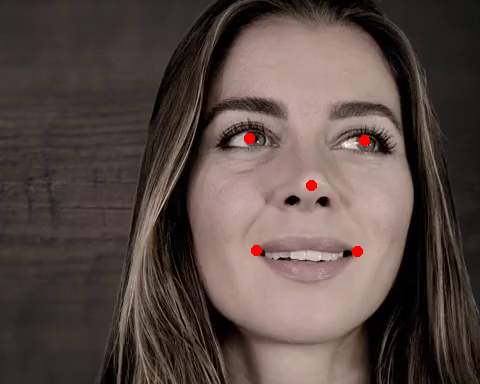

In [1]:
from medusa.data import get_example_image
from medusa.detect import SCRFDetector
from torchvision.utils import draw_keypoints, save_image
from IPython.display import Image, Video

detector = SCRFDetector()
img = get_example_image()
out = detector(img)

draw = draw_keypoints(img[0].byte(), out['lms'], colors=(255, 0, 0), radius=5)
save_image(draw / 255., 'lms5.png')
Image('lms5.png')

Although these five landmarks are sufficient for alignment (and is in fact used in the `AlignCropModel` class, as we'll see later), they're not ideal to base a bounding box on (as in the `BboxCropModel` class), because from the landmarks alone you do not know the full width and height of the face and therefore do not know how wide/tall the bounding box should be!

Fortunately, the kind folks at [Insightface](https://insightface.ai/) did not only make their face detection model (used for Medusa's `SCRFDectector` class) open source, but also their 2D and 3D landmark models, which output either 106 (2D) or 68 (3D) landmarks! 

Medusa contains an efficient wrapper around these landmark models: `RetinafaceLandmarkModel`. Using the `model_name` parameter, you can determine whether you want to return 106 or 68 landmarks (use '1k3d68' for 68 landmarks, or '2d106det' for 106 landmarks); note that we discard the depth dimension for the 3D landmark model, so that the output is always $L$ (number of landmarks) $\times 2$.

Let's checkout the '2d106det' model:

In [2]:
from medusa.landmark import RetinafaceLandmarkModel

lm_model = RetinafaceLandmarkModel('2d106det')
out_106 = lm_model(img)

print(out_106.keys())

dict_keys(['conf', 'bbox', 'lms', 'img_idx', 'n_img'])


As you can see, the landmark model outputs the face detection results (which it applied before landmark detection), but replaces the 'lms' data with the new landmarks:

In [3]:
tuple(out_106['lms'].shape)  # (batch, n_landmarks, XY)

(1, 106, 2)

We can visualize these landmarks as before:

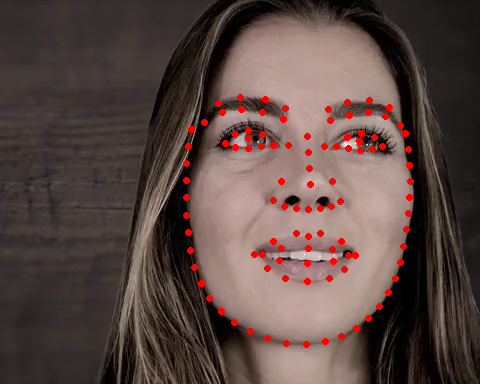

In [4]:
draw = draw_keypoints(img[0].byte(), out_106['lms'], colors=(255, 0, 0), radius=3)
save_image(draw / 255., 'lms106.png')
Image('lms106.png')

To show the difference with the 68-landmark model, we'll run it again (this time with the '1k3d68' model) and plot the detected landmarks on top of the previous image (106-lm model in red; 68-lm model in green):

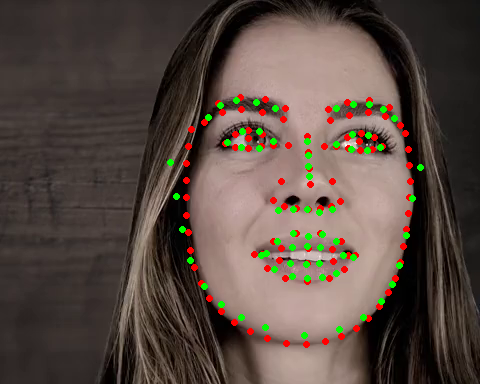

In [5]:
lm_model = RetinafaceLandmarkModel('1k3d68')
out_68 = lm_model(img)

draw = draw_keypoints(draw, out_68['lms'], colors=(0, 255, 0), radius=3)
save_image(draw / 255., 'lms106+68.png')
Image('lms106+68.png')

Like most functionality in Medusa, the landmark model can be run on batches of images, like series of video frames! We show this below and visualize it using the `BatchResults` class:

In [6]:
from medusa.data import get_example_video
from medusa.containers import BatchResults

lm_model = RetinafaceLandmarkModel('2d106det')
vid = get_example_video(return_videoloader=True, batch_size=256)
batch = next(iter(vid)).to(lm_model.device)
out = lm_model(batch)

results = BatchResults(**out)
results.visualize('./lms.mp4', imgs=batch, video=True)

Video('./lms.mp4', embed=True)

Note that, in addition to the landmarks from the landmark model, `BatchResults` also shows the bounding box and confidence score returned by the detector.

## Cropping

In Medusa, there are two approaches for cropping: a bounding-box based method and an alignment-based method. We'll discuss these in turn.

### Bounding-box based cropping

In our bounding-box (bbox) based cropping method, we use a rectangular bounding box to "cut out" the face such that the face is roughly in the center of the image. You might think, 'great, we can use the `bbox` from the face detection model outputs for this!', but that isn't as straightforward as it looks. First, this bbox is rectangular, while most reconstruction models (including DECA/EMOCA-based models in Medusa) expect square images (e.g., $224 \times 224$). Also, and this is more of a pragmatic issue, the cropping procedure should be *exactly the same* as the procedure used when training the reconstruction model. And it turns out that DECA and EMOCA, Medusa's prime reconstruction models, used a very specific procedure.

In short, these models would do the following:

1. use a 68-landmark model to estimate facial landmarks
2. create a bbox based on the landmarks closest to the image borders
3. slightly enlarge the bbox
4. make the bbox square
5. use the final bbox to crop the image

In Medusa, we implemented this procedure in the `BboxCropModel` class, which is nearly identical to the original DECA implementation, except that we use a faster and more accurate landmark estimation model (i.e., the `1k3d68` version of the `RetinafaceLandmarkModel`).

We'll show you how this class is used below:

In [7]:
from medusa.crop import BboxCropModel

# 224 x 224 is the expected cropped image size for the DECA/EMOCA models
crop_model = BboxCropModel(lms_model_name='1k3d68', output_size=(224, 224))
out_crop = crop_model(img)

print(out_crop.keys())

dict_keys(['conf', 'bbox', 'lms', 'img_idx', 'n_img', 'imgs_crop', 'crop_mat'])


Like the landmark model, the crop model outputs both the outputs from the detection model (`conf`, `lms`, etc) as well as three new outputs: `bbox` (the *new* bbox, which replaced the one from the face detection model), `imgs_crop` and `crop_mat`. 

Below, we'll run the detection model separately to compare the bbox returned by the detection model (in red) and the bbox created by the crop model (in green):

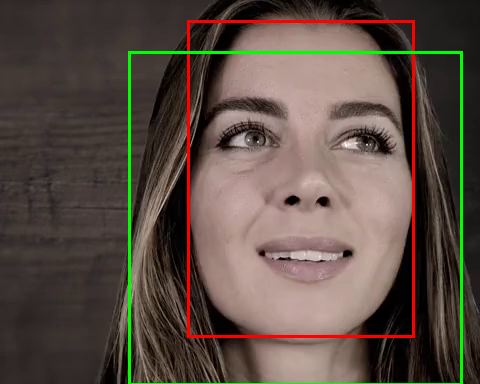

In [8]:
from torchvision.utils import draw_bounding_boxes
from medusa.detect import SCRFDetector

det_model = SCRFDetector()
out_det = det_model(img)

draw = draw_bounding_boxes(img[0].byte(), out_det['bbox'], colors=(255, 0, 0), width=3)
draw = draw_bounding_boxes(draw, out_crop['bbox'], colors=(0, 255, 0), width=3)
save_image(draw / 255., 'bbox_compare.png')
Image('bbox_compare.png')

Now, as the name suggests, `imgs_crop` contains the cropped images of each face detected in the original image. As expected, the image is now square and in the dimensions specified when initializing the crop model (i.e., $224 \times 224$):

In [9]:
# N (detections) x 3 (RGB) x H x W
out_crop['imgs_crop'].shape

torch.Size([1, 3, 224, 224])

which looks like the following:

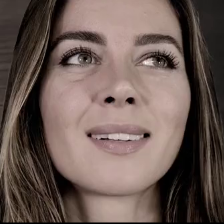

In [10]:
save_image(out_crop['imgs_crop'] / 255., 'crop.png')
Image('crop.png')

This leaves us with `crop_mat`:

In [11]:
crop_mat = out_crop['crop_mat']
tuple(crop_mat.shape)  # N (detections) x 3 x 3

(1, 3, 3)

The 'crop_mat' output represents (for each detection) a $3 \times 3$ affine matrix that represents (slightly simplified) the cropping operation as a similarity transform of the corners of the image to the corners of the bounding box. This matrix can then be used to warp the pixels of the original image to create the cropped image. Although `BboxCropModel` does this for you (and returns the results as `imgs_crop`), we'll show below how this is in fact done using the `crop_mat`. We'll use `warp_affine` from the awesome [Kornia](https://kornia.readthedocs.io/) package:

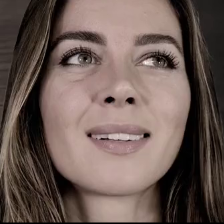

In [12]:
from kornia.geometry.transform import warp_affine

# warp_affine expects a N x 2 x 3 matrix, so we remove the last row
img_crop = warp_affine(img, out_crop['crop_mat'][:, :2, :], dsize=(224, 224))
save_image(img_crop / 255., 'crop_manual.png')
Image('crop_manual.png')

So, in essence the `crop_mat` is a way to move between the original image space and the cropped image space. This means we can also project the cropped image back into the original image space using the *inverse* of the `crop_mat`!

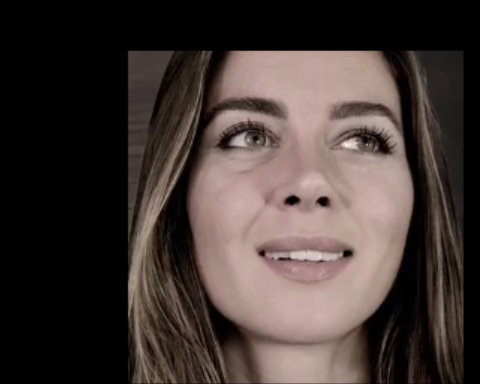

In [13]:
import torch

inv_crop_mat = torch.inverse(out_crop['crop_mat'])
img_uncrop = warp_affine(img_crop, inv_crop_mat[:, :2, :], dsize=(img.shape[2], img.shape[3]))

save_image(img_uncrop, 'uncrop.png', normalize=True)
Image('uncrop.png')

Crucially, the `crop_mat` can also be used to move points (rather than pixels), like landmarks, between the original and cropped image space. For example, if we would like to plot the landmarks (which are defined in the original image space) on the cropped image, we can project them in cropped image space as follows (using the `transform_points` function from Kornia): 

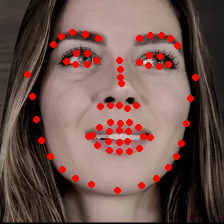

In [14]:
from kornia.geometry.linalg import transform_points
lms_cropped = transform_points(crop_mat, out_crop['lms'])

draw = draw_keypoints(img_crop[0].byte(), lms_cropped, colors=(255, 0, 0), radius=3)
save_image(draw / 255., 'lms_crop.png')
Image('lms_crop.png')

This crop matrix is in fact also important for rendering 3D reconstruction results! We include the translation and scaling introduced by the cropping operation into the affine (world) matrix of the 3D object such that, when rendered, it is projected in the original image rather than the cropped image space!

### Alignment-based cropping

In addition to the bbox-based cropping model, Medusa also includes an alignment-based crop model, `AlignCropModel`, which is used to crop images for the MICA reconstruction model (and other Arcface-based models, like the `RetinafaceRecognitionModel`). This model will align the face landmarks in the image to a template set of landmarks. The template used by the model, by default, is the set of five landmarks we have seen before, defined in an image space of $112 \times 112$ pixels:

In [15]:
from medusa.crop.align_crop import TEMPLATE
print(TEMPLATE)

tensor([[38.2946, 51.6963],
        [73.5318, 51.5014],
        [56.0252, 71.7366],
        [41.5493, 92.3655],
        [70.7299, 92.2041]])


which we can show as follows:

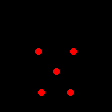

In [16]:
background = torch.zeros((3, 112, 112)).byte()
draw = draw_keypoints(background, TEMPLATE.unsqueeze(0), colors=(255, 0, 0), radius=3)
save_image(draw / 255., 'lm_template.png')
Image('lm_template.png')

To align the face landmarks from the image (provided by the face detection model) to the template, the `AlignCropModel` will estimate a similarity transform (giving us a crop matrix again!):

In [17]:
from medusa.crop import AlignCropModel

crop_model = AlignCropModel(output_size=(224, 224))
out_crop = crop_model(img)

out_crop.keys()

dict_keys(['imgs_crop', 'crop_mat', 'conf', 'bbox', 'lms', 'img_idx', 'n_img'])

Here, `lms` represents the aligned landmarks. Let's see how well the model did by plotting both the template landmarks (in red) and the aligned landmarks (in green) on top of the cropped image:

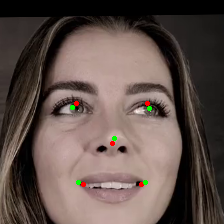

In [19]:
draw = draw_keypoints(out_crop['imgs_crop'][0].byte(), TEMPLATE.unsqueeze(0) * 2, colors=(255, 0, 0), radius=2)

# Note that the aligned landmarks are (by default) in original image space, so 
lms = transform_points(out_crop['crop_mat'], out_crop['lms'])
draw = draw_keypoints(draw, lms, colors=(0, 255, 0), radius=2)
save_image(draw / 255., 'lm_aligned.png')
Image('lm_aligned.png')

The `AlignCropModel` (like the `BboxCropModel` for that matter) also work on batches of images, which can be visualized using `BatchResults`. Only issue is that `torchvision` does not support drawing rotated bounding boxes, so instead we visualize the aligned images in cropped image space:

In [21]:
vid = get_example_video(return_videoloader=True, batch_size=512)
batch = next(iter(vid)).to(lm_model.device)
out = crop_model(batch)

results = BatchResults(**out)
results.sort_faces()
results.visualize('./align_crop.mp4', imgs=batch, video=True, show_cropped=True, crop_size=(224, 224), template=TEMPLATE * 2)

Video('./align_crop.mp4', embed=True)